# Introduction

This is a comparison of the SETI@home doppler drift code against the phython code.

First some helper code...  This returns the barycentric velocity correction in a specific direction.

In [219]:
# corrs.py
import math
import numpy as np
from astropy.time import Time
from astropy.coordinates import SkyCoord, solar_system, EarthLocation, ICRS, CartesianRepresentation, UnitSphericalRepresentation
from astropy import units as u



def velcorr(time, skycoord, location=None):
  """Barycentric velocity correction.
  
  Uses the ephemeris set with  ``astropy.coordinates.solar_system_ephemeris.set`` for corrections. 
  For more information see `~astropy.coordinates.solar_system_ephemeris`.
  
  Parameters
  ----------
  time : `~astropy.time.Time`
    The time of observation.
  skycoord: `~astropy.coordinates.SkyCoord`
    The sky location to calculate the correction for.
  location: `~astropy.coordinates.EarthLocation`, optional
    The location of the observatory to calculate the correction for.
    If no location is given, the ``location`` attribute of the Time
    object is used
    
  Returns
  -------
  vel_corr : `~astropy.units.Quantity`
    The velocity correction to convert to Barycentric velocities. Should be added to the original
    velocity.
  """
  
  if location is None:
    if time.location is None:
        raise ValueError('An EarthLocation needs to be set or passed '
                         'in to calculate bary- or heliocentric '
                         'corrections')
    location = time.location
  
  ep, ev = solar_system.get_body_barycentric_posvel('earth', time) # ICRS position and velocity of Earth's geocenter
  op, ov = location.get_gcrs_posvel(time) # GCRS position and velocity of observatory
  # ICRS and GCRS are axes-aligned. Can add the velocities
  velocity = ev + ov # relies on PR5434 being merged
  
  # get unit ICRS vector in direction of SkyCoord
  sc_cartesian = skycoord.icrs.represent_as(UnitSphericalRepresentation).represent_as(CartesianRepresentation)
  return sc_cartesian.dot(velocity).to(u.km/u.s) # similarly requires PR5434



The SETI@home code uses the Arecibo observatory corrdinates (both astronomical and geodetic).  This only has
one coordinate possible so we'll use the Arecibo geodetic coordinates.

In [220]:
AO=EarthLocation.of_site("Arecibo Observatory")
AO.geodetic


GeodeticLocation(lon=<Longitude -66.75277778 deg>, lat=<Latitude 18.34416667 deg>, height=<Quantity 497. m>)


Just a note that this doesn't match the geodetic coordinates that I've been using, which proably means that they are using a different ellipsoid than I use.  It shouldn't make a difference if everything is consistent.  It is also different than the Astronomical coordinates used for determining where Arecibo was pointing.  The gravitational acceleration is not perpendicular to the ellipsoid at Arecibo.  This is also likely to be true at FAST, but it is my understanding that at FAST the direction of the gravity is ignored and geodetic coordinates are used for astronomical positions.

Next we need something to look at, and a time.  I've pulled the 1 billionth workunit generated for SETI@home and am taking its time and coordinates
JD=2455628.794039 RA(hours)=13.65615430833, Dec(deg)=33.23895434779

In [221]:
pos=SkyCoord(13.65615430833*15,33.23895434779,unit="deg",equinox="J2000",obstime=Time(2455628.794039,format="jd",location=AO))
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (204.84231462, 33.23895435)>

In [222]:
pos.obstime

<Time object: scale='utc' format='jd' value=2455628.794039>

OK, now lets get the barycentric correction

In [223]:
corr=velcorr(pos.obstime,pos)
corr

<Quantity 8.41758242 km / s>

So according to the comments, this is the correction the velocity of an astronomical object.  So if a star was measured to have a radial velocity of zero, its corrected velocity would be +8.4 km/s with respect to the barycenter and we would expect its observed radio frequency to be $\frac{c+8.4\frac{\rm km}{\rm s}}{c} \nu_o$ where $\nu_o$ is the emitted frequency.  In other words the observed emission is blue shifted.  So for an emitted frequency of 1.420 GHz, the observed frequency would be....

In [224]:
c=299792458*u.meter/u.second
nu_corr=math.sqrt((1+corr/c)/(1-corr/c))
nu=1.420e+9*u.Hz
nu1=nu*nu_corr
nu1.decompose().to_string(precision=14)


'1.42003987136610e+09 1 / s'

If we want the doppler drift rate due to the motion of the earth we need to do the same calculation before an after the point.


In [225]:
#two points a second apart
corr0=velcorr(pos.obstime-0.5*u.second,pos)
corr1=velcorr(pos.obstime+0.5*u.second,pos)
nu_corr0=math.sqrt((1+corr0/c)/(1-corr0/c))
nu_corr1=math.sqrt((1+corr1/c)/(1-corr1/c))
drift=nu*(nu_corr1-nu_corr0)/u.second
drift.decompose()


<Quantity -0.14821716 1 / s2>

Since the doppler drift is dominated by the Earth's rotation which is an acceleration toward the axis, and telescopes usually point up, the drift rate will almost always be negative.

Now lets compare the SETI@home doppler code.  The program to calculate an observed frequency from a barycentric frequency is called "detection_frequency"

> % ./detection_freq -jd 2455628.794039 -ra 13.65615430833 -decl 33.23895434779 -baryfreq 1420000000 -epoch 2000.0

> JD 2455628.794039 LST 13.649352 RA 13.656154 Declination 33.238954 detection frequency 1420039875.533216 barycentric frequency 1420000000.000000 offset (bary-det) -39875.533216 barycentric chirp -0.148083


So there are some small differences in the acceleration model used.  Frequencies differ by 5 Hz and drift rates by a part in $10^{-4}$.  That shouldn't be big enough to cause a problem because our detection windows are much larger than that.  So we should be able to use the astropy routines.


# Application to a Work Unit

I've put a workunit in the directory with this called "work_unit.sah."  We'll read it and use the appropriate fields to calculate the
barycentric doppler drift rate of the observation... 

Someone needs to write a function that will read a workunit and all it's parameters...  Since that doesn't yet exist
we will look at the parameters manually.


Does astropy have the FAST coordinates correct?  This should match what is in the workunit header.

In [226]:
FAST=EarthLocation.of_site("FAST")
FAST.geodetic

GeodeticLocation(lon=<Longitude 106.85666642 deg>, lat=<Latitude 25.65294616 deg>, height=<Quantity 1109.10232229 m>)

Here's the workunit header

    <latitude>25.652944</latitude>
    <longitude>106.856667</longitude>
    <elevation>1110.0288</elevation>

Slightly different...  Hmmm....  Possibly another difference between geodetic and geocentric coordinates, or possibly the model speroid used. How far apart a they


In [227]:
math.sqrt((((FAST.geodetic.lon-106.856667*u.degree).radian*63870000*u.meter)**2+
     ((FAST.geodetic.lat-25.652944*u.degree).radian*63870000*u.meter)**2+
     (FAST.geodetic.height-1110.0288*u.meter)**2)/u.meter**2)*u.meter

<Quantity 2.66404509 m>

Not a huge difference, so we'll call them the same.  If we were doing nanosecond timing or nanoHz spectroscopy, this might make a difference.

Now the sky position at the start and end of the workunit.

    <start_time>2459847.1418726854</start_time>
    <start_ra>23.657972</start_ra>
    <start_dec>20.843028</start_dec>


In [228]:
pos0=SkyCoord(23.657972*15,20.843028,unit="deg",equinox="J2000",obstime=Time(2459847.1418726854,format="jd",location=FAST))
pos0

<SkyCoord (ICRS): (ra, dec) in deg
    (354.86958, 20.843028)>

The last position should be in the final set of coordinates.

    <coordinate_t>
      <time>2459847.1426828704</time>
      <ra>23.677431</ra>
      <dec>20.841556</dec>
    </coordinate_t>


In [229]:
pos1=SkyCoord(23.677431*15,20.841556,unit="deg",equinox="J2000",obstime=Time(2459847.1426828704,format="jd",location=FAST))
pos1

<SkyCoord (ICRS): (ra, dec) in deg
    (355.161465, 20.841556)>

In [230]:
corr0=velcorr(pos0.obstime,pos0)
corr0

<Quantity 0.9603178 km / s>

In [231]:
corr1=velcorr(pos1.obstime,pos1)
corr1

<Quantity 1.08823797 km / s>

The difference in time between these two observations is...

In [232]:
dur=(pos1.obstime-pos0.obstime).to_value('sec')*u.second
dur

<Quantity 69.99998242 s>

This should be equal to 1 Mi / subband_sample_rate

In [233]:
1024*1024/15258.7890625*u.second

<Quantity 68.71947674 s>

It's not, which probably indicates a possible problem with work unit generation, probably the last coordinate is after the end of data.  That should not bother the SETI@home client.  It should not affect this work either.

These are the barycentric corrections at the start and end of the observation.  Expressed as acceleration that is...

In [234]:
accel=(corr1-corr0)/dur
accel

<Quantity 0.00182743 km / s2>

Now find the frequency we are correcting for.  For this work we can only do one frequency per workunit, the central frequency.

    <center>1420364379.882812</center>

In [235]:
nu=1420364379.882812*u.Hz
nu

<Quantity 1.42036438e+09 Hz>

Noe we have to calculate the doppler drift over that time

In [236]:
#two points a second apart
nu_corr0=math.sqrt((1+corr0/c)/(1-corr0/c))
nu_corr1=math.sqrt((1+corr1/c)/(1-corr1/c))
drift=nu*(nu_corr1-nu_corr0)/dur
drift.decompose()


<Quantity 8.6580814 1 / s2>

Now you should be confused, because I said the Doppler drift would almost always be negative, and 8.55 Hz/s is larger than it should be and has the opposite sign that it should.

That's because I deliberately made a mistake that crop up a lot in SETI.  I've calculated the Doppler drift using two different coordinates.  So I've calculated the Doppler drift of an object moving across the sky.  That's not what we're looking for.  If I calculate
the doppler drif at the start and end position.  Lets start by defining a function for the Doppler drift.

In [237]:

def doppler_drift(pos, nu):
  corr0=velcorr(pos.obstime-0.5*u.second,pos)
  corr1=velcorr(pos.obstime+0.5*u.second,pos)
  nu_corr0=math.sqrt((1+corr0/c)/(1-corr0/c))
  nu_corr1=math.sqrt((1+corr1/c)/(1-corr1/c))
  drift=nu*(nu_corr1-nu_corr0)/u.second
  return drift


In [238]:
drift0=doppler_drift(pos0,nu)
drift0

<Quantity -0.15761643 Hz / s>

In [239]:
drift1=doppler_drift(pos1,nu)
drift1

<Quantity -0.1576322 Hz / s>

Those are better answers...  So the average drift rate over the workunit is:

In [240]:
drift=(drift0+drift1)/2
drift

<Quantity -0.15762432 Hz / s>

Now we need to grab the data from the file

In [241]:
data=np.fromfile("work_unit.sah", dtype=np.int8)
print(type(data))
# The start is at 15063 bytes into the file 
# every file will be different!  A workunit reader should be able to exctract the header and data in the form of a structure.
# I don't think I have time to write this
print(data.__len__())
data=data[15062:15062+2*1024*1024]
print(data.__len__())


<class 'numpy.ndarray'>
2112188
2097126


That second number should be 2097152.  It is not.  There is something wrong with the workunit generator.  The data section is too short by a significant amount.

Check the distribution of samples.

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

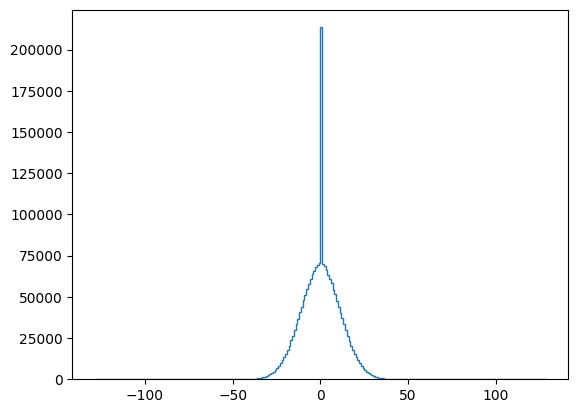

In [242]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(data,bins=256,range=[-128.5,128.5],histtype='step')

Looks fine, apart from +0 and -0 being folded into the same bin.